# WLS-EV Analysis

In [1]:
"""
KIT CRAM Seminar WS17/18
Algorithmic Design - Least squares estimates weighted by ex-ante return variance (WLS-EV)
"""

__author__ = 'Tobias Kuhlmann'

# Import own libraries
from wlsev.variance_estimation import ExAnteVariance
from wlsev.wlsev_model import Wlsev_model
from wlsev.ols_model import OLS_model
from tools.visualisation import plot_results, plot_scatter, plot_results_custom, plot_scatter_custom
# import general packages
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline


/Users/tobias/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Preprocessing

### Read in log return data and variance

### Log returns

In [2]:
# Import price data and calc log returns
# --------------------------------------------------
es_50_prices = pd.read_csv('data/eurostoxx50_prices_eod.csv', parse_dates=True)
# set index, rename and check
es_50_prices['loctimestamp'] =pd.to_datetime(es_50_prices['loctimestamp'])
es_50_prices = es_50_prices.rename(columns={'loctimestamp': 'date'})
es_50_prices = es_50_prices.set_index('date')

#Log Returns
es_50_logret = es_50_prices
es_50_logret['logreturns'] = (np.log(es_50_prices['lastprice'] / es_50_prices['lastprice'].shift(1))).dropna()

del es_50_logret['lastprice']

### Volatility data: old version of Simons file, new calculation in P-moments

In [3]:
# Import vol data
# --------------------------------------------------
es_50_vol = pd.read_csv('data/es50_volatility.csv', parse_dates=True)
# Transform dates
es_50_vol['loctimestamp'] = pd.to_datetime(es_50_vol['loctimestamp'])
# Delete unnecessary columns
del es_50_vol['instrumentid']
# Calculate variance from vol
es_50_vol['variance'] = es_50_vol['volatility'] ** 2
del es_50_vol['volatility']
# set index, rename and check
es_50_vol = es_50_vol.rename(columns={'loctimestamp': 'date'})
es_50_vol = es_50_vol.set_index('date')

### Implied volatility data: old version of Simons file, new calculation in Q-moments

In [4]:
# Import implied volatility
# --------------------------------------------------
#es_50_imp_vol = pd.read_csv('data/es50_implied_volatility.csv', parse_dates=True)
# Transform dates
#es_50_imp_vol['loctimestamp'] = pd.to_datetime(es_50_imp_vol['loctimestamp'])
# Delete unnecessary columns
#del es_50_imp_vol['instrumentid']
#del es_50_imp_vol['maturity']
# Calculate implied variance from implied vol
#es_50_imp_vol['implied_var'] = es_50_imp_vol['measure'] ** 2
#del es_50_imp_vol['measure']
# set index, rename and check
#es_50_imp_vol = es_50_imp_vol.rename(columns={'loctimestamp': 'date'})
#es_50_imp_vol = es_50_imp_vol.set_index('date')

### Riskfree rate

In [5]:
# Import riskfree rate data
# --------------------------------------------------
rf = pd.read_csv('data/riskfree_rate.csv', parse_dates=True, sep=';')
# Transform dates
rf['loctimestamp'] = pd.to_datetime(rf['loctimestamp'])
# set index, rename and check
rf = rf.rename(columns={'loctimestamp': 'date'})
rf = rf.set_index('date')

### VRP data

In [6]:
# Import VRP data
# --------------------------------------------------
es_50_vrp = pd.read_csv('data/eurostoxx50_vrp.csv', parse_dates=True, sep=';')
# Transform dates
es_50_vrp['loctimestamp'] = pd.to_datetime(es_50_vrp['loctimestamp'])
# set index, rename and check
es_50_vrp = es_50_vrp.rename(columns={'loctimestamp': 'date'})
es_50_vrp = es_50_vrp.set_index('date')

### ERP data

In [7]:
# Calculate ERP from logrets and riskfree rate
# Take risk free rate maturity 7 (smallest maturity)
rf_mat7 = rf[rf['daystomaturity'] == 7].shift(-1) / 252
# Calculate ERP = logrets - rf
es_50_erp = pd.DataFrame({'erp': (es_50_logret['logreturns'] - rf_mat7['riskfree']).dropna()})

### Q-Moments data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x108d94470>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1084aeda0>], dtype=object)

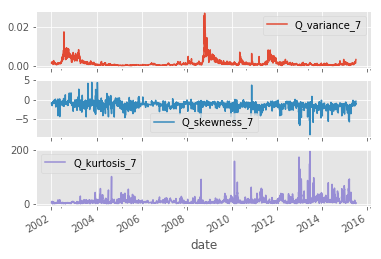

In [8]:
# Import Q-Moments data
# --------------------------------------------------
es_50_q = pd.read_csv('data/FiglewskiStandardizationEOD_DE0009652396D1_Qmoments.csv', parse_dates=True, sep = ';')
es_50_q.head(5)
# Transform dates
es_50_q['loctimestamp'] = pd.to_datetime(es_50_q['loctimestamp'])
# set index, rename and check
es_50_q = es_50_q.rename(columns={'loctimestamp': 'date'})
es_50_q = es_50_q.set_index('date')

# Delete unnecessary columns
del es_50_q['underlyingprice']
del es_50_q['underlyingforwardprice']
del es_50_q['Q_cubic']
del es_50_q['Q_quartic']

# Split maturities into seperate columns
es_50_q_7 = es_50_q[es_50_q['daystomaturity'] == 7]
es_50_q_7 = es_50_q_7.rename(columns={'Q_variance': 'Q_variance_7', 'Q_skewness': 'Q_skewness_7', 'Q_kurtosis': 'Q_kurtosis_7'})
del es_50_q_7['daystomaturity']

es_50_q_30 = es_50_q[es_50_q['daystomaturity'] == 30]
es_50_q_30 = es_50_q_30.rename(columns={'Q_variance': 'Q_variance_30', 'Q_skewness': 'Q_skewness_30', 'Q_kurtosis': 'Q_kurtosis_30'})
del es_50_q_30['daystomaturity']
# define 30 day maturity as implied vol
es_50_imp_vol = es_50_q_30['Q_variance_30']

es_50_q_60 = es_50_q[es_50_q['daystomaturity'] == 60]
es_50_q_60 = es_50_q_60.rename(columns={'Q_variance': 'Q_variance_60', 'Q_skewness': 'Q_skewness_60', 'Q_kurtosis': 'Q_kurtosis_60'})
del es_50_q_60['daystomaturity']

es_50_q_91 = es_50_q[es_50_q['daystomaturity'] == 91]
es_50_q_91 = es_50_q_91.rename(columns={'Q_variance': 'Q_variance_91', 'Q_skewness': 'Q_skewness_91', 'Q_kurtosis': 'Q_kurtosis_91'})
del es_50_q_91['daystomaturity']

es_50_q_182 = es_50_q[es_50_q['daystomaturity'] == 182]
es_50_q_182 = es_50_q_182.rename(columns={'Q_variance': 'Q_variance_182', 'Q_skewness': 'Q_skewness_182', 'Q_kurtosis': 'Q_kurtosis_182'})
del es_50_q_182['daystomaturity']

es_50_q_365 = es_50_q[es_50_q['daystomaturity'] == 365]
es_50_q_365 = es_50_q_365.rename(columns={'Q_variance': 'Q_variance_365', 'Q_skewness': 'Q_skewness_365', 'Q_kurtosis': 'Q_kurtosis_365'})
del es_50_q_365['daystomaturity']

es_50_q_7.plot(subplots = True)

### P-Moments data including return variance

In [9]:
# Import 5 min price data and calc log returns
# --------------------------------------------------
es_50_prices_5 = pd.read_csv('data/eurostoxx50_prices_5m.csv', parse_dates=True, sep=';')
# set index, rename and check
es_50_prices_5 = es_50_prices_5.rename(columns={'loctimestamp': 'date'})
es_50_prices_5['date'] = pd.to_datetime(es_50_prices_5['date'], errors='coerce')
es_50_prices_5 = es_50_prices_5.set_index('date')

#Log Returns
es_50_logret_5 = es_50_prices_5
es_50_logret_5['logreturns5min'] = np.log(es_50_prices_5['price'] / es_50_prices_5['price'].shift(1))
es_50_logret_5 = es_50_logret_5.dropna()

# Count of values per day
N = (es_50_logret_5.loc[(es_50_logret_5.index >= '2004-07-04 00:00:00') & (es_50_logret_5.index <= '2004-07-06 00:00:00')]).shape[0]

# Calculate moments after Amaya, Christoffersen, Jacobs, Vasquez (2015) - Does realized skewness predict equity returns
es_50_logret_5['logreturns_pow2'] = es_50_logret_5['logreturns5min'] ** 2
es_50_logret_5['logreturns_pow3'] = es_50_logret_5['logreturns5min'] ** 3
es_50_logret_5['logreturns_pow4'] = es_50_logret_5['logreturns5min'] ** 4

# group by date and sum up
helper = es_50_logret_5.groupby(es_50_logret_5.index.date).sum()

# Var 1 day = sum of intraday squared returns
es_50_P_1 = pd.DataFrame({'var1': helper['logreturns_pow2']})
# Skewness daily and variance of skewness: Var(x) = E_t[x^2] - E^2[x]
es_50_P_1['skewness1'] = helper['logreturns_pow3']
es_50_P_1['var_skewness1'] = es_50_logret_5['logreturns_pow3'].groupby(es_50_logret_5.index.date).var()
#es_50_P_1['var_skewness1'] = es_50_P_1['skewness1'] #- np.mean(es_50_P_1['skewness1']) ** 2
# Kurtosis daily and variance of kurtosis: Var(x) = E_t[x^2] - E^2[x]
es_50_P_1['kurtosis1'] = helper['logreturns_pow4']
es_50_P_1['var_kurtosis1'] = es_50_logret_5['logreturns_pow4'].groupby(es_50_logret_5.index.date).var()
#es_50_P_1['var_kurtosis1'] = es_50_P_1['kurtosis1'] ** 2 #- np.mean(es_50_P_1['kurtosis1']) ** 2

/Users/tobias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tobias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tobias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

### Fama-French data

In [10]:
# Import Fama French Factors
# --------------------------------------------------
# HML and SMB
es_50_ff = pd.read_csv('data/FamaFrench_Europe_3_Factors_Daily.csv', parse_dates=True, skiprows=6)
es_50_ff = es_50_ff.rename(columns={'Unnamed: 0': 'date'})
es_50_ff['date'] = pd.to_datetime(es_50_ff['date'], format = '%Y%m%d')
es_50_ff = es_50_ff.set_index('date')

# Momentum Factor
es_50_ff2 = pd.read_csv('data/FamaFrench_Europe_MOM_Factor_Daily.csv', parse_dates=True, skiprows=6)
es_50_ff2 = es_50_ff2.rename(columns={'Unnamed: 0': 'date'})
es_50_ff2['date'] = pd.to_datetime(es_50_ff2['date'], format = '%Y%m%d')
es_50_ff2 = es_50_ff2.set_index('date')

# Join and drop na's
es_50_ff = es_50_ff.join(es_50_ff2).dropna()

## Join data for correct dates

In [11]:
# Join data
data_vrperp = pd.concat([es_50_logret, es_50_vol, es_50_imp_vol, es_50_vrp, es_50_erp], join='inner', axis=1).dropna()
data_retvol = pd.concat([es_50_logret, es_50_vol], join='inner', axis=1).dropna()
data_retimpvol = pd.concat([es_50_logret, es_50_vol], join='inner', axis=1).dropna()
data_qff = pd.concat([es_50_q_7, es_50_q_30, es_50_q_60, es_50_q_91, es_50_q_182, es_50_q_365, es_50_ff], join='inner', axis=1).dropna()
data_pq = pd.concat([es_50_q_7, es_50_q_30, es_50_q_60, es_50_q_91, es_50_q_182, es_50_q_365, es_50_P_1], join='inner', axis=1).dropna()

#data_wop.plot(subplots=True)
print(data_vrperp.shape)
print(data_retvol.shape)
print(data_retimpvol.shape)
print(data_qff.shape)
print(data_pq.shape)

(2962, 5)
(3815, 2)
(3815, 2)
(2713, 23)
(688, 23)


# Visualisation

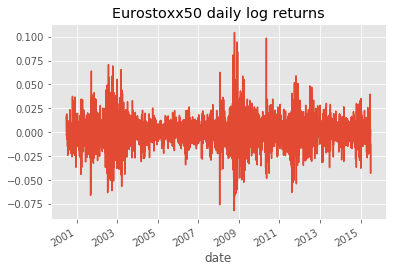

In [12]:
# log return plot
plt = data_retvol['logreturns'].plot(title='Eurostoxx50 daily log returns')
# get figure to save
plt = plt.get_figure()
plt.savefig('../Presentation/figures/euro50_logreturns.png')


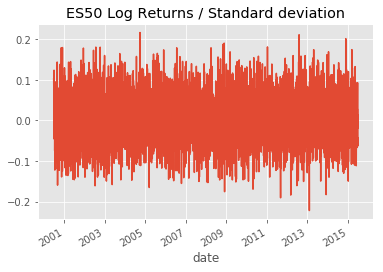

In [13]:
# log return plot
plt = (data_retvol['logreturns'] / data_retvol['variance'] ** 0.5).plot(title='ES50 Log Returns / Standard deviation')
# get figure to save
plt = plt.get_figure()
plt.savefig('../Presentation/figures/euro50_logstandard.png')


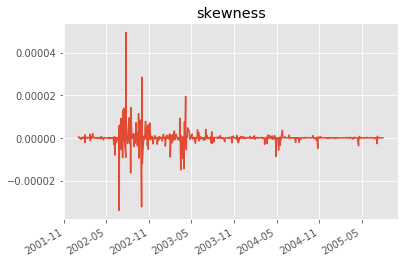

In [14]:
# skewness plot
(data_pq['skewness1']).plot(title='skewness')

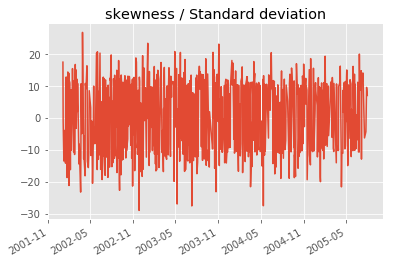

In [15]:
# standardized skewness
(data_pq['skewness1'] / data_pq['var_skewness1'] ** 0.5).plot(title='skewness / Standard deviation')

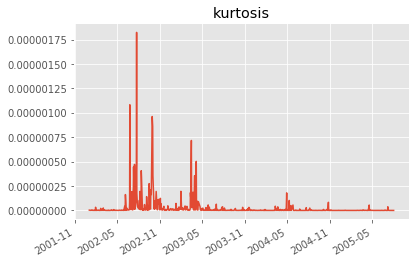

In [16]:
# kurtosis
(data_pq['kurtosis1']).plot(title='kurtosis')

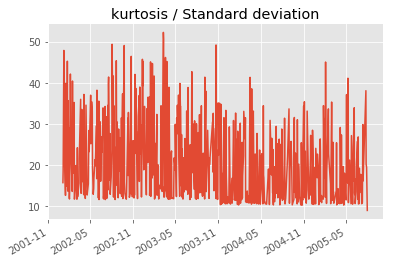

In [18]:
# standardized kurtosis
(data_pq['kurtosis1'] / data_pq['var_kurtosis1'] ** 0.5).plot(title='kurtosis / Standard deviation')

Index(['Q_variance_7', 'Q_skewness_7', 'Q_kurtosis_7', 'Q_variance_30',
       'Q_skewness_30', 'Q_kurtosis_30', 'Q_variance_60', 'Q_skewness_60',
       'Q_kurtosis_60', 'Q_variance_91', 'Q_skewness_91', 'Q_kurtosis_91',
       'Q_variance_182', 'Q_skewness_182', 'Q_kurtosis_182', 'Q_variance_365',
       'Q_skewness_365', 'Q_kurtosis_365', 'var1', 'skewness1',
       'var_skewness1', 'kurtosis1', 'var_kurtosis1'],
      dtype='object')


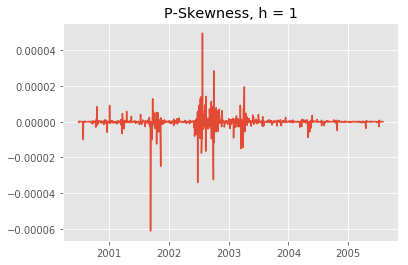

In [19]:
# P Moment plot
print(data_pq.columns)
plt = es_50_P_1['skewness1'].plot(title='P-Skewness, h = 1')
# get figure to save
plt = plt.get_figure()
plt.savefig('../Presentation/figures/p_skewness_1.png')

# Model and Analysis

## Estimate Ex ante Variance

In [20]:
# Model and Analysis
# ==================================================
#
# 1. Estimate (sigma_t)2, the (ex ante) conditional variance of next-period unexpected returns epsilon_(t+1)
# using a HAR-RV (Hierachical Autoregressive-Realized Variance) Model from Corsi (2009)
# ------------------------------------------------------------------------------------------------------------
# Log return variance
# ------------------------------------------------------------------------------------------------------------
ea_var_obj = ExAnteVariance(data_retvol['variance']) # no implied vol
#ea_var_obj = ExAnteVariance(data_wop['variance'], data_wop['implied_var']) # implied vol
result = ea_var_obj.estimate_variance() # Estimate Variance
# Join returns and estimated variance
# for return on return regression
data_retvol_var = data_retvol.join(pd.DataFrame({'var_logret_daily_est': result}).dropna()).dropna() # merge for correct indexing
# for erp on vrp regression
data_vrperp_var = data_vrperp.join(pd.DataFrame({'var_logret_daily_est': result}).dropna()).dropna() # merge for correct indexing


# P Moments variances for different maturities / forecast horizons
# ------------------------------------------------------------------------------------------------------------
ea_var_obj_skewness1 = ExAnteVariance(data_pq['var_skewness1']) 
result_skewness1 = ea_var_obj_skewness1.estimate_variance() # Estimate Variance
ea_var_obj_kurtosis1 = ExAnteVariance(data_pq['var_kurtosis1']) 
result_kurtosis1 = ea_var_obj_kurtosis1.estimate_variance() # Estimate Variance

# Join returns and estimated variance
result_variances = pd.DataFrame({'var_est_skewness1': result_skewness1, 'var_est_kurtosis1': result_kurtosis1
                 }).dropna()
data_pq_var = data_pq.join(result_variances).dropna() # merge for correct indexing

# Fama French Factor variances for different maturities / forecast horizons
# ------------------------------------------------------------------------------------------------------------

Variance Estimation Object initialized!
Variance Estimation begins!
Variance Estimation Results
                            OLS Regression Results                            
Dep. Variable:          var_daily_est   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     2598.
Date:                Thu, 22 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:45:23   Log-Likelihood:                -3378.2
No. Observations:                3793   AIC:                             6764.
Df Residuals:                    3789   BIC:                             6789.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

## WLS-EV and benchmark estimations

### Regress returns on returns

##### Forecast horizon 1,22,44, 66, 88

WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.0001 -0.0345]
robust bse standard errors: [ 0.0002  0.0152]
t-stats: [-0.7566 -2.2707]
In sample R_squared: 0.0013
Out of sample R_squared: 0.0032
-------------------------------------------------------------------------------------------------------


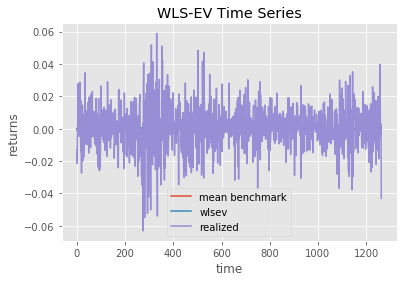

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.0001 -0.0269]
robust bse standard errors: [ 0.0003  0.0235]
t-stats: [-0.5216 -1.1441]
In sample R_squared: 0.0007
Out of sample R_squared: 0.001
-------------------------------------------------------------------------------------------------------


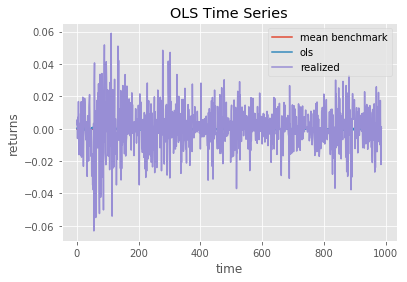

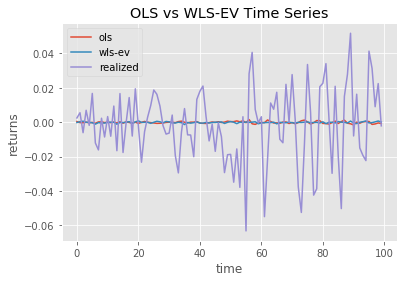

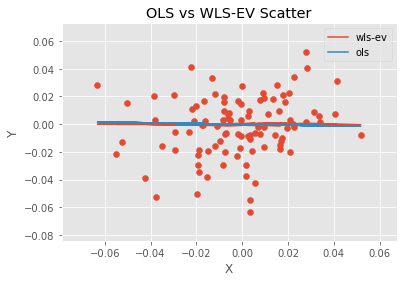

WLS-EV Estimation Results
Forecast Horizon: 7
-------------------------------------------------------------------------------------------------------
betas: [-0.0009 -0.1189]
robust bse standard errors: [ 0.0015  0.046 ]
t-stats: [-0.632  -2.5811]
In sample R_squared: 0.0041
Out of sample R_squared: 0.0048
-------------------------------------------------------------------------------------------------------


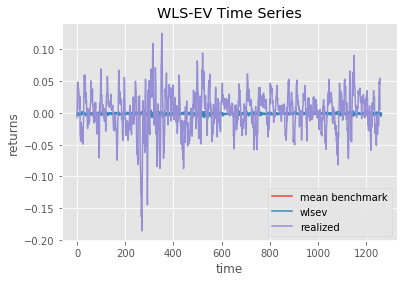

OLS Estimation Results
Forecast Horizon: 7
-------------------------------------------------------------------------------------------------------
betas: [-0.0009 -0.1326]
robust bse standard errors: [ 0.0015  0.0559]
t-stats: [-0.5879 -2.3746]
In sample R_squared: 0.0031
Out of sample R_squared: 0.0026
-------------------------------------------------------------------------------------------------------


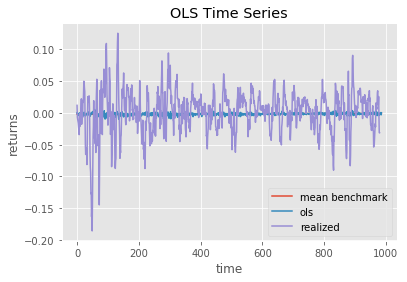

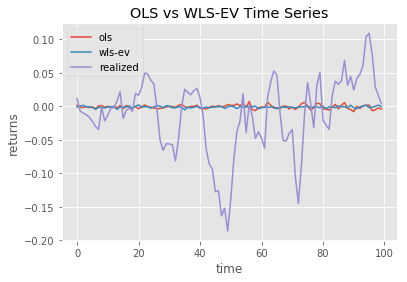

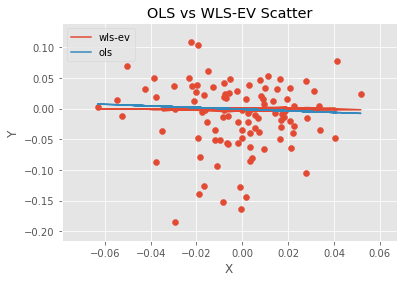

WLS-EV Estimation Results
Forecast Horizon: 14
-------------------------------------------------------------------------------------------------------
betas: [-0.002  -0.0724]
robust bse standard errors: [ 0.0032  0.0656]
t-stats: [-0.6319 -1.1032]
In sample R_squared: 0.0012
Out of sample R_squared: 0.0035
-------------------------------------------------------------------------------------------------------


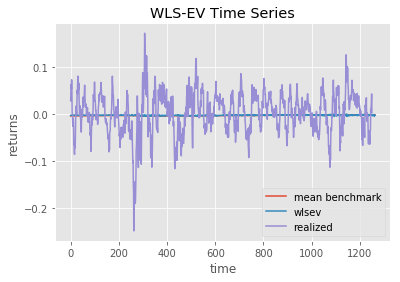

OLS Estimation Results
Forecast Horizon: 14
-------------------------------------------------------------------------------------------------------
betas: [-0.0017 -0.089 ]
robust bse standard errors: [ 0.0023  0.0785]
t-stats: [-0.7364 -1.1337]
In sample R_squared: 0.0007
Out of sample R_squared: 0.0014
-------------------------------------------------------------------------------------------------------


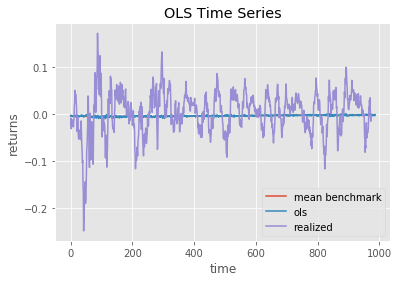

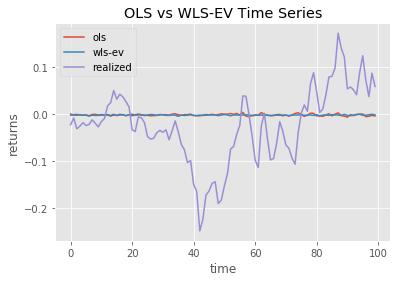

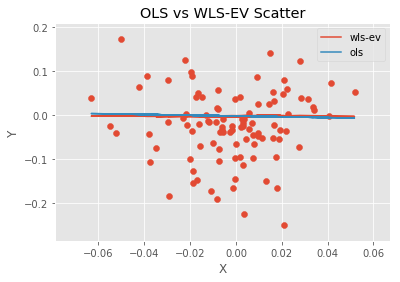

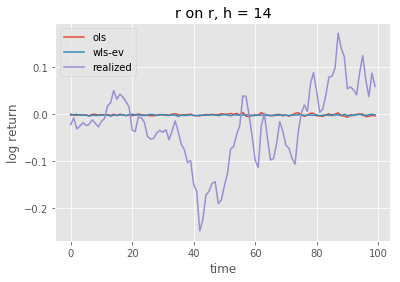

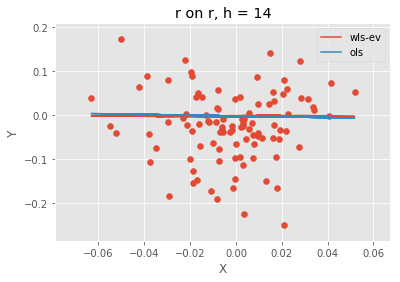

WLS-EV Estimation Results
Forecast Horizon: 22
-------------------------------------------------------------------------------------------------------
betas: [-0.0032 -0.0534]
robust bse standard errors: [ 0.0053  0.0842]
t-stats: [-0.6006 -0.6338]
In sample R_squared: 0.0006
Out of sample R_squared: 0.0047
-------------------------------------------------------------------------------------------------------


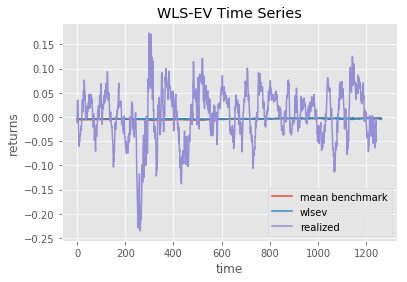

OLS Estimation Results
Forecast Horizon: 22
-------------------------------------------------------------------------------------------------------
betas: [-0.0027 -0.1201]
robust bse standard errors: [ 0.003   0.0903]
t-stats: [-0.8847 -1.3311]
In sample R_squared: 0.0008
Out of sample R_squared: 0.0005
-------------------------------------------------------------------------------------------------------


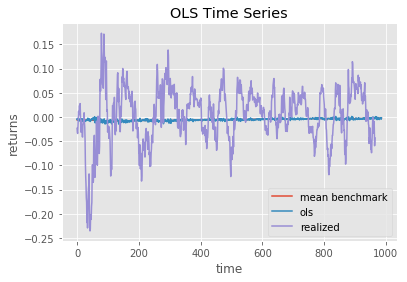

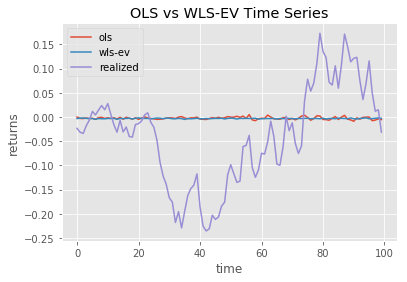

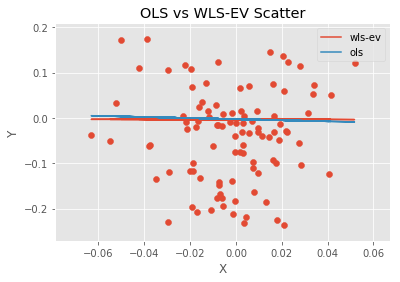

WLS-EV Estimation Results
Forecast Horizon: 44
-------------------------------------------------------------------------------------------------------
betas: [-0.0059 -0.0994]
robust bse standard errors: [ 0.0113  0.1211]
t-stats: [-0.5187 -0.8207]
In sample R_squared: 0.0004
Out of sample R_squared: 0.0138
-------------------------------------------------------------------------------------------------------


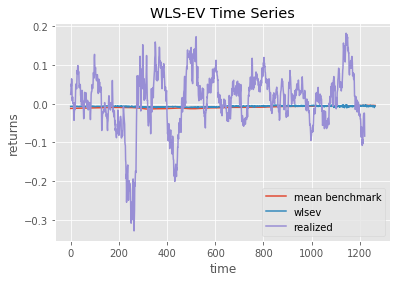

OLS Estimation Results
Forecast Horizon: 44
-------------------------------------------------------------------------------------------------------
betas: [-0.005  -0.0832]
robust bse standard errors: [ 0.0045  0.1208]
t-stats: [-1.1063 -0.6888]
In sample R_squared: 0.0002
Out of sample R_squared: 0.0002
-------------------------------------------------------------------------------------------------------


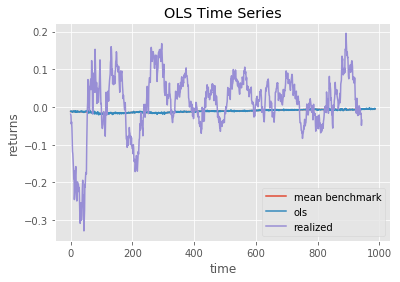

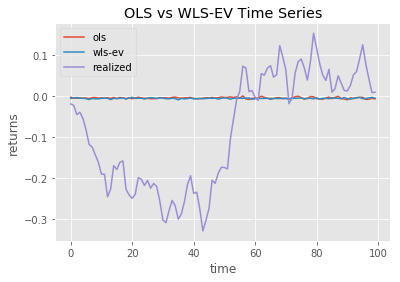

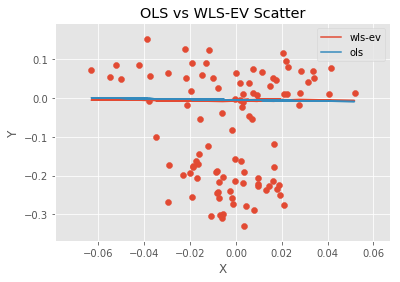

WLS-EV Estimation Results
Forecast Horizon: 66
-------------------------------------------------------------------------------------------------------
betas: [-0.0084 -0.0115]
robust bse standard errors: [ 0.0178  0.1507]
t-stats: [-0.4738 -0.0763]
In sample R_squared: -0.0005
Out of sample R_squared: 0.0195
-------------------------------------------------------------------------------------------------------


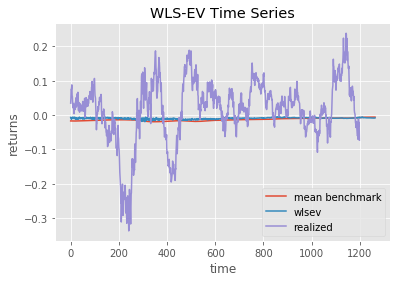

OLS Estimation Results
Forecast Horizon: 66
-------------------------------------------------------------------------------------------------------
betas: [-0.0077 -0.0619]
robust bse standard errors: [ 0.0056  0.143 ]
t-stats: [-1.378  -0.4326]
In sample R_squared: 0.0001
Out of sample R_squared: 0.0001
-------------------------------------------------------------------------------------------------------


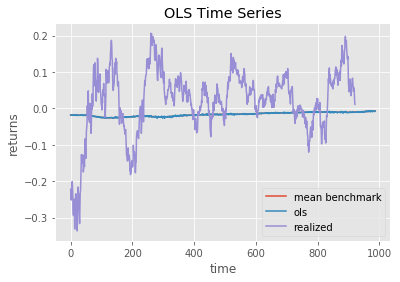

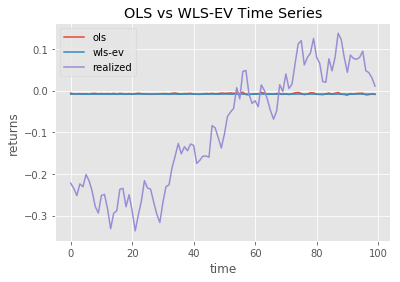

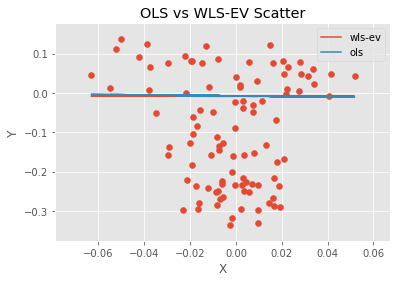

WLS-EV Estimation Results
Forecast Horizon: 88
-------------------------------------------------------------------------------------------------------
betas: [-0.0109  0.0738]
robust bse standard errors: [ 0.0241  0.1704]
t-stats: [-0.4536  0.4333]
In sample R_squared: -0.0008
Out of sample R_squared: 0.023
-------------------------------------------------------------------------------------------------------


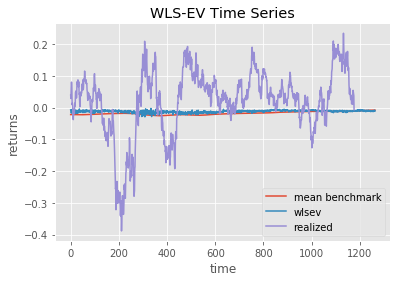

OLS Estimation Results
Forecast Horizon: 88
-------------------------------------------------------------------------------------------------------
betas: [-0.0103  0.0235]
robust bse standard errors: [ 0.0067  0.1648]
t-stats: [-1.5387  0.1425]
In sample R_squared: 0.0
Out of sample R_squared: -0.0009
-------------------------------------------------------------------------------------------------------


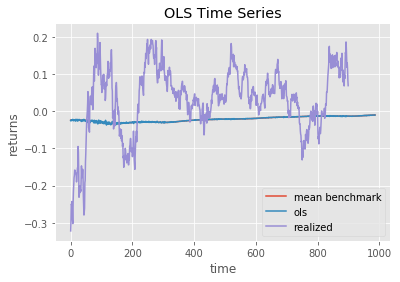

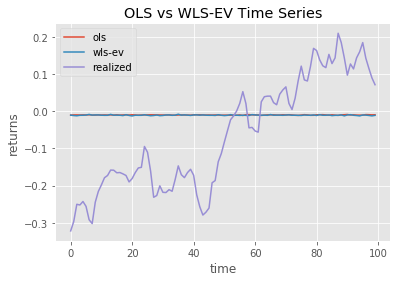

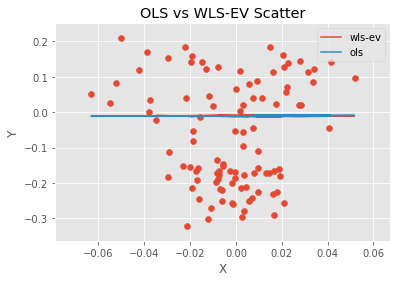

In [21]:
# 2. least squares estimates weighted by ex-ante return variance (WLS-EV) using Johnson (2016)
# ------------------------------------------------------------------------------------------------------------

for i in (1, 7, 14, 22,44, 66, 88):
    # set forecast_horizon
    forecast_horizon = i

    # WLS-EV
    wlsev_obj = Wlsev_model(data_retvol_var['logreturns'][:-1].as_matrix(), data_retvol_var['logreturns'][1:].as_matrix(), data_retvol_var['var_logret_daily_est'][:-1].as_matrix(), forecast_horizon)
    wlsev_obj.fit()
    # OOS evaluation to get Rsquared
    wlsev_obj.evaluate()
    wlsev_obj.print_results()
    wlsev_obj.plot_results()
    # get data
    X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

    # OLS
    ols_obj = OLS_model(data_vrperp_var['logreturns'][:-1].as_matrix(), data_vrperp_var['logreturns'][1:].as_matrix(), forecast_horizon)
    ols_obj.fit()
    # OOS evaluation to get Rsquared
    ols_obj.evaluate()
    ols_obj.print_results()
    ols_obj.plot_results()
    # get data
    X, Y, y_ols = ols_obj.get_plot_data_ols()


    # Visualisation
    # ------------------------------------------------------------------------------------------------------------

    # time series plot
    plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
    # scatter plot
    plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])

    if forecast_horizon == 14:
        # time series plot
        plt = plot_results_custom(X[:100],Y[:100],y_wlsev[:100], y_ols[:100], 'r on r, h = 14', 'log return')
        # scatter plot
        plt = plot_scatter_custom(X[:100],Y[:100],y_wlsev[:100], y_ols[:100], 'r on r, h = 14')

### Regress ERP on VRP

##### forecast horizon several months ahead months

WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.0002 -0.0021]
robust bse standard errors: [ 0.0002  0.0094]
t-stats: [-0.779  -0.2278]
In sample R_squared: 0.0002
Out of sample R_squared: -0.0017
-------------------------------------------------------------------------------------------------------


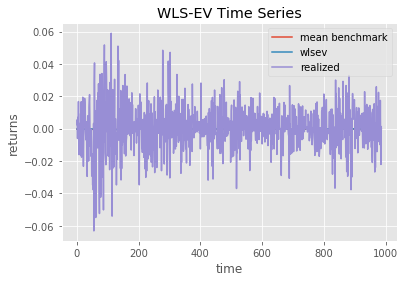

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.0004 -0.0088]
robust bse standard errors: [ 0.0003  0.0113]
t-stats: [-1.3762 -0.78  ]
In sample R_squared: 0.0005
Out of sample R_squared: 0.002
-------------------------------------------------------------------------------------------------------


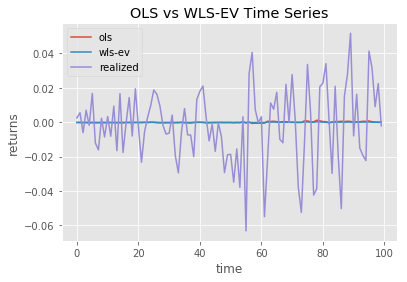

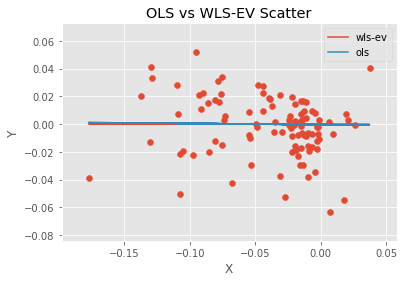

WLS-EV Estimation Results
Forecast Horizon: 22
-------------------------------------------------------------------------------------------------------
betas: [-0.0025  0.0359]
robust bse standard errors: [ 0.0043  0.1748]
t-stats: [-0.574   0.2055]
In sample R_squared: -0.003
Out of sample R_squared: -0.0012
-------------------------------------------------------------------------------------------------------


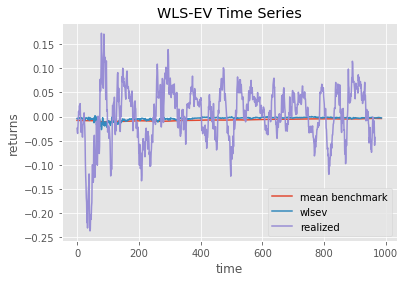

OLS Estimation Results
Forecast Horizon: 22
-------------------------------------------------------------------------------------------------------
betas: [-0.0061 -0.091 ]
robust bse standard errors: [ 0.003   0.0856]
t-stats: [-2.029  -1.0623]
In sample R_squared: 0.003
Out of sample R_squared: -0.001
-------------------------------------------------------------------------------------------------------


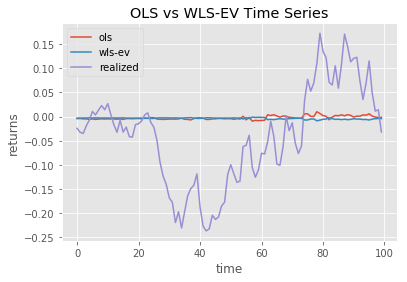

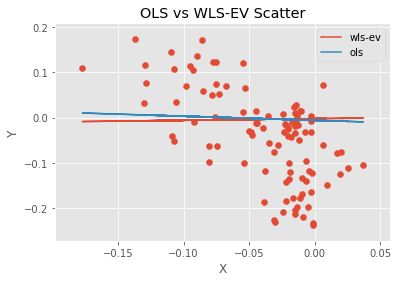

WLS-EV Estimation Results
Forecast Horizon: 44
-------------------------------------------------------------------------------------------------------
betas: [-0.0044  0.1881]
robust bse standard errors: [ 0.0085  0.3487]
t-stats: [-0.5243  0.5396]
In sample R_squared: -0.0127
Out of sample R_squared: -0.0087
-------------------------------------------------------------------------------------------------------


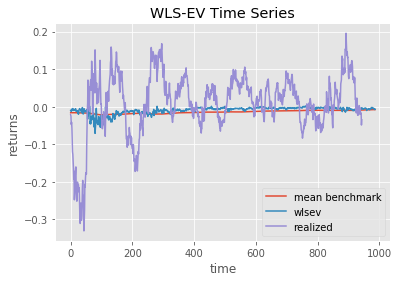

OLS Estimation Results
Forecast Horizon: 44
-------------------------------------------------------------------------------------------------------
betas: [-0.0099 -0.0958]
robust bse standard errors: [ 0.0046  0.1085]
t-stats: [-2.1491 -0.8829]
In sample R_squared: 0.0016
Out of sample R_squared: -0.0061
-------------------------------------------------------------------------------------------------------


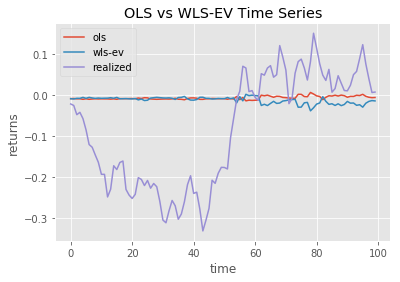

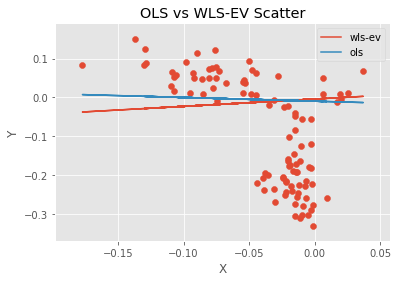

WLS-EV Estimation Results
Forecast Horizon: 66
-------------------------------------------------------------------------------------------------------
betas: [-0.0055  0.2447]
robust bse standard errors: [ 0.0126  0.5185]
t-stats: [-0.4369  0.4719]
In sample R_squared: -0.0163
Out of sample R_squared: 0.0215
-------------------------------------------------------------------------------------------------------


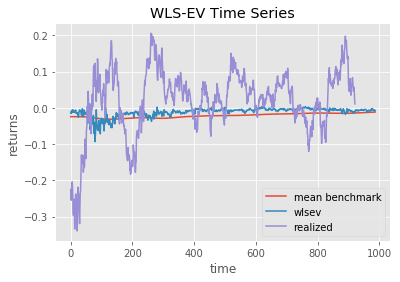

OLS Estimation Results
Forecast Horizon: 66
-------------------------------------------------------------------------------------------------------
betas: [-0.0156 -0.1635]
robust bse standard errors: [ 0.0061  0.1414]
t-stats: [-2.5629 -1.1561]
In sample R_squared: 0.0031
Out of sample R_squared: -0.0177
-------------------------------------------------------------------------------------------------------


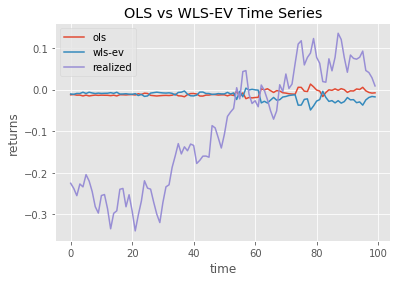

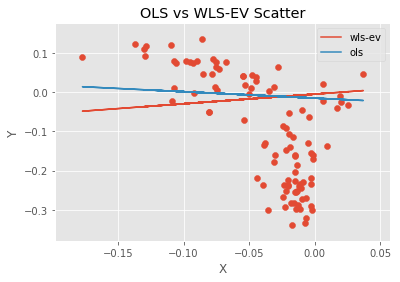

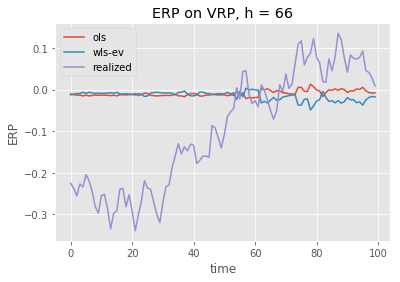

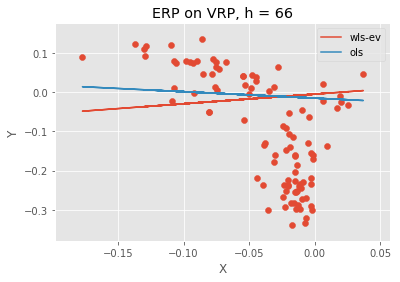

WLS-EV Estimation Results
Forecast Horizon: 88
-------------------------------------------------------------------------------------------------------
betas: [-0.0057  0.166 ]
robust bse standard errors: [ 0.0167  0.6743]
t-stats: [-0.34    0.2462]
In sample R_squared: -0.0133
Out of sample R_squared: 0.101
-------------------------------------------------------------------------------------------------------


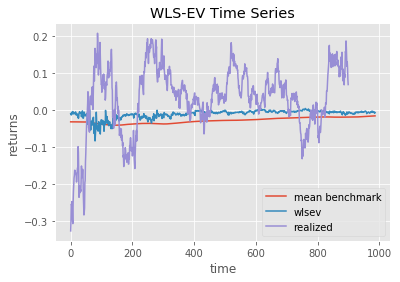

OLS Estimation Results
Forecast Horizon: 88
-------------------------------------------------------------------------------------------------------
betas: [-0.0236 -0.3346]
robust bse standard errors: [ 0.0074  0.1292]
t-stats: [-3.1997 -2.5902]
In sample R_squared: 0.0092
Out of sample R_squared: -0.0459
-------------------------------------------------------------------------------------------------------


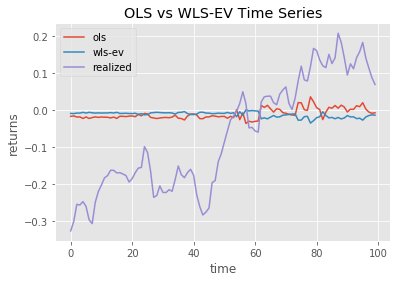

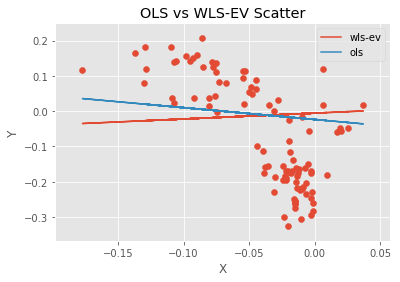

In [22]:
# set forecast_horizon
for i in (1,22,44, 66, 88):
    forecast_horizon = i

    # WLS-EV
    wlsev_obj = Wlsev_model(data_vrperp_var['vrp'][:-1].as_matrix(), data_vrperp_var['erp'][1:].as_matrix(), data_vrperp_var['var_logret_daily_est'][:-1].as_matrix(), forecast_horizon)
    wlsev_obj.fit()
    # OOS evaluation to get Rsquared
    wlsev_obj.evaluate()
    wlsev_obj.print_results()
    wlsev_obj.plot_results()
    # get data
    X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

    # OLS
    ols_obj = OLS_model(data_vrperp_var['vrp'][:-1].as_matrix(), data_vrperp_var['erp'][1:].as_matrix(), forecast_horizon)
    ols_obj.fit()
    # OOS evaluation to get Rsquared
    ols_obj.evaluate()
    ols_obj.print_results()
    # get data
    X, Y, y_ols = ols_obj.get_plot_data_ols()


    # Visualisation
    # ------------------------------------------------------------------------------------------------------------

    # time series plot
    plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
    # scatter plot
    plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
    
    if forecast_horizon == 66:
        # time series plot
        plt = plot_results_custom(X[:100],Y[:100],y_wlsev[:100], y_ols[:100], 'ERP on VRP, h = 66', 'ERP')
        # scatter plot
        plt = plot_scatter_custom(X[:100],Y[:100],y_wlsev[:100], y_ols[:100], 'ERP on VRP, h = 66')

### Regress P-Moments on Q-Moments


### P_skewness_1 = f(Q_skewness_7) + error

P_skewness_1 = f(Q_skewness_7) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 3.4348  3.0328]
In sample R_squared: 0.0002
Out of sample R_squared: 0.0283
-------------------------------------------------------------------------------------------------------


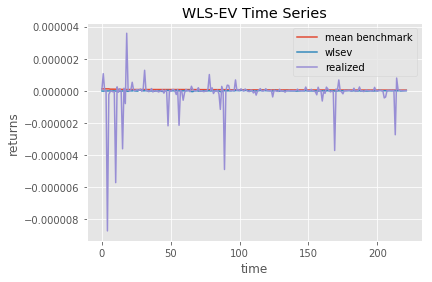

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 1.2857  1.8007]
In sample R_squared: 0.0026
Out of sample R_squared: -0.016
-------------------------------------------------------------------------------------------------------


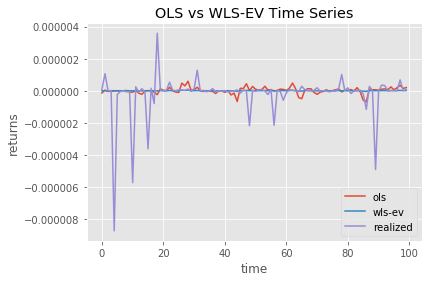

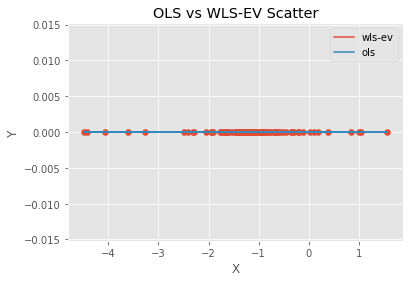

In [36]:
forecast_horizon = 1

# P_skewness_7 = f(Q_skewness_7) + error
print('P_skewness_1 = f(Q_skewness_7) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_7'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), data_pq_var['var_est_skewness1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_7'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
# scatter plot
plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])

### P_skewness_7 = f(Q_skewness_7) + error

P_skewness_7 = f(Q_skewness_7) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 7
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 2.3352  1.9035]
In sample R_squared: -0.0007
Out of sample R_squared: 0.1784
-------------------------------------------------------------------------------------------------------


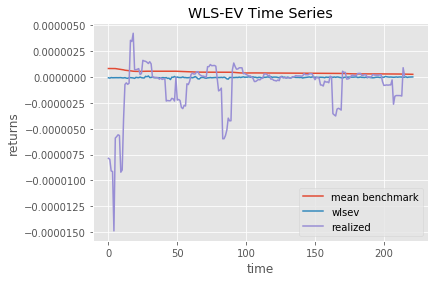

OLS Estimation Results
Forecast Horizon: 7
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 1.0107  1.5602]
In sample R_squared: 0.0085
Out of sample R_squared: 0.0471
-------------------------------------------------------------------------------------------------------


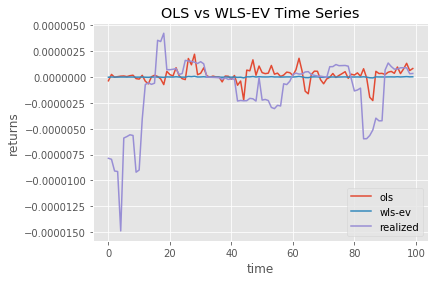

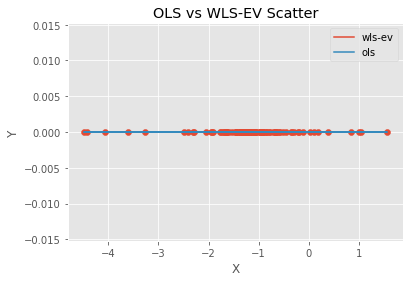

In [23]:
forecast_horizon = 7

# P_skewness_7 = f(Q_skewness_7) + error
print('P_skewness_7 = f(Q_skewness_7) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_7'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), data_pq_var['var_est_skewness1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_7'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
# scatter plot
plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])

### P_kurtosis_7 = f(Q_kurtosis_7) + error

P_kurtosis_7 = f(Q_kurtosis_7) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 7
-------------------------------------------------------------------------------------------------------
betas: [ 0. -0.]
robust bse standard errors: [ 0.  0.]
t-stats: [  1.5636 -10.5145]
In sample R_squared: -0.1728
Out of sample R_squared: 0.9484
-------------------------------------------------------------------------------------------------------


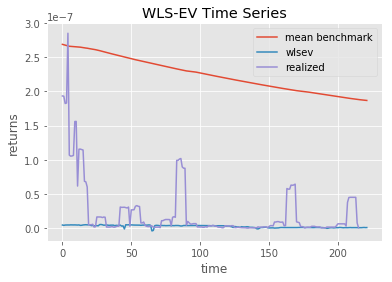

OLS Estimation Results
Forecast Horizon: 7
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 1.0107  1.5602]
In sample R_squared: 0.0085
Out of sample R_squared: 0.0471
-------------------------------------------------------------------------------------------------------


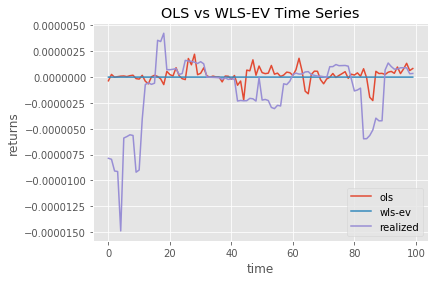

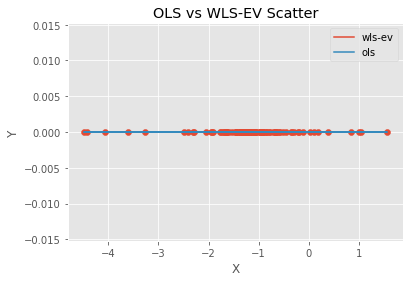

In [24]:
forecast_horizon = 7

# P_kurtosis_7 = f(Q_kurtosis_7) + error
print('P_kurtosis_7 = f(Q_kurtosis_7) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_7'][:-1].as_matrix(), data_pq_var['kurtosis1'][1:].as_matrix(), data_pq_var['var_est_kurtosis1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_7'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
# scatter plot
plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])

### P_skewness_30 = f(Q_skewness_30) + error

P_skewness_30 = f(Q_skewness_30) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 30
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 0.4782  0.3806]
In sample R_squared: -0.0055
Out of sample R_squared: 0.5594
-------------------------------------------------------------------------------------------------------


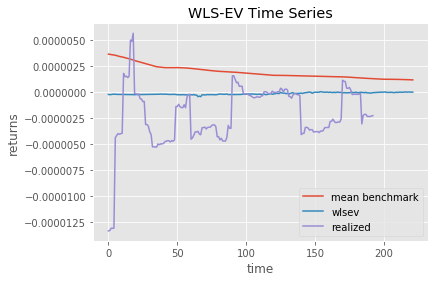

OLS Estimation Results
Forecast Horizon: 30
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 2.6938  3.8205]
In sample R_squared: 0.0513
Out of sample R_squared: -0.0506
-------------------------------------------------------------------------------------------------------


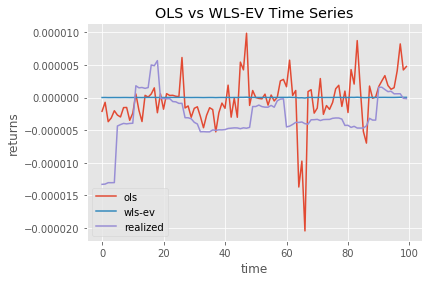

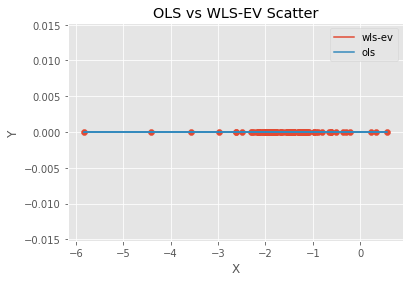

In [25]:
forecast_horizon = 30

# P_skewness_30 = f(Q_skewness_30) + error
print('P_skewness_30 = f(Q_skewness_30) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_30'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), data_pq_var['var_est_skewness1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_30'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
# scatter plot
plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])

### P_kurtosis_30 = f(Q_kurtosis_30) + error

P_kurtosis_30 = f(Q_kurtosis_30) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 30
-------------------------------------------------------------------------------------------------------
betas: [ 0. -0.]
robust bse standard errors: [ 0. -0.]
t-stats: [ 0.5543  0.6085]
In sample R_squared: -0.3338
Out of sample R_squared: 0.9897
-------------------------------------------------------------------------------------------------------


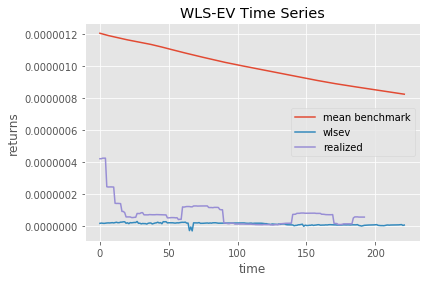

OLS Estimation Results
Forecast Horizon: 30
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 2.6938  3.8205]
In sample R_squared: 0.0513
Out of sample R_squared: -0.0506
-------------------------------------------------------------------------------------------------------


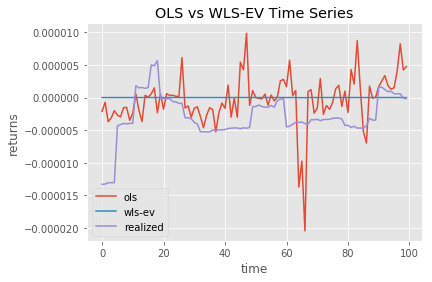

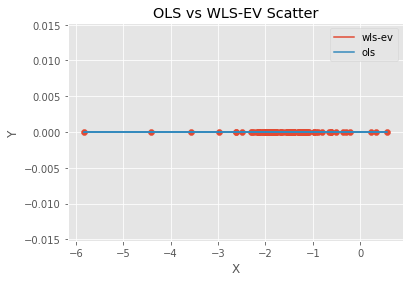

In [26]:
forecast_horizon = 30

# P_kurtosis_30 = f(Q_kurtosis_30) + error
print('P_kurtosis_30 = f(Q_kurtosis_30) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_30'][:-1].as_matrix(), data_pq_var['kurtosis1'][1:].as_matrix(), data_pq_var['var_est_kurtosis1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_30'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
# scatter plot
plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])

### P_skewness_60 = f(Q_skewness_60) + error

P_skewness_60 = f(Q_skewness_60) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 60
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 0.8456  0.7286]
In sample R_squared: -0.0121
Out of sample R_squared: 0.718
-------------------------------------------------------------------------------------------------------


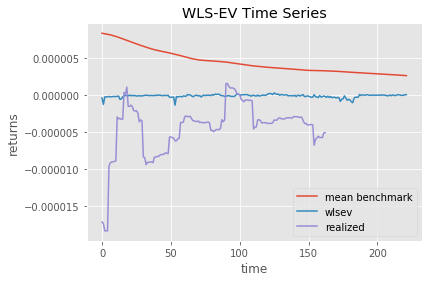

OLS Estimation Results
Forecast Horizon: 60
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 3.6883  4.2172]
In sample R_squared: 0.1282
Out of sample R_squared: -0.1776
-------------------------------------------------------------------------------------------------------


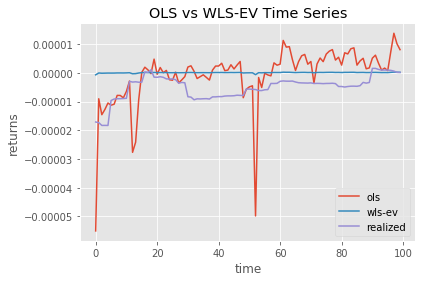

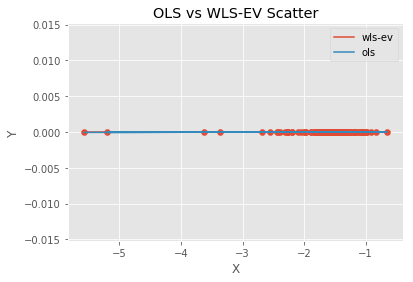

In [27]:
forecast_horizon = 60

# P_skewness_60 = f(Q_skewness_60) + error
print('P_skewness_60 = f(Q_skewness_60) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_60'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), data_pq_var['var_est_skewness1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_60'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
# scatter plot
plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])

### P_kurtosis_60 = f(Q_kurtosis_60) + error

P_kurtosis_60 = f(Q_kurtosis_60) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 60
-------------------------------------------------------------------------------------------------------
betas: [ 0. -0.]
robust bse standard errors: [ 0. -0.]
t-stats: [ 0.8433  0.9049]
In sample R_squared: -0.4921
Out of sample R_squared: 0.9956
-------------------------------------------------------------------------------------------------------


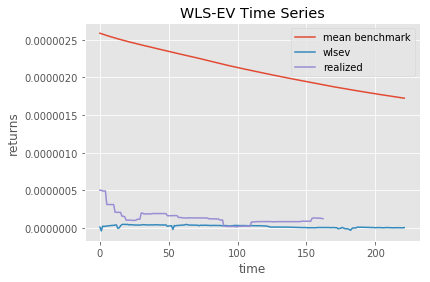

OLS Estimation Results
Forecast Horizon: 60
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 3.6883  4.2172]
In sample R_squared: 0.1282
Out of sample R_squared: -0.1776
-------------------------------------------------------------------------------------------------------


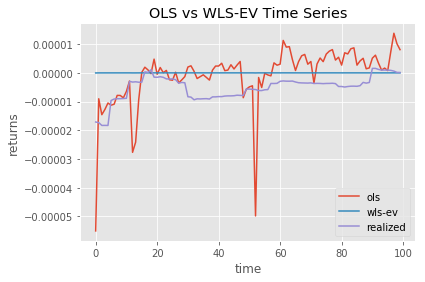

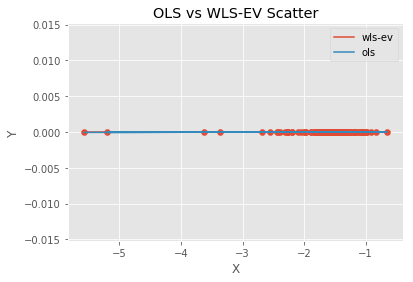

In [28]:
forecast_horizon = 60

# P_kurtosis_60 = f(Q_kurtosis_60) + error
print('P_kurtosis_60 = f(Q_kurtosis_60) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_60'][:-1].as_matrix(), data_pq_var['kurtosis1'][1:].as_matrix(), data_pq_var['var_est_kurtosis1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_60'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
# scatter plot
plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])

### P_skewness_91 = f(Q_skewness_91) + error

P_skewness_91 = f(Q_skewness_91) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 91
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 2.8517  2.2788]
In sample R_squared: -0.0307
Out of sample R_squared: 0.8298
-------------------------------------------------------------------------------------------------------


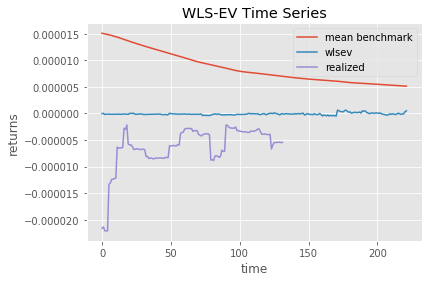

OLS Estimation Results
Forecast Horizon: 91
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 5.1321  5.8919]
In sample R_squared: 0.1387
Out of sample R_squared: 0.1622
-------------------------------------------------------------------------------------------------------


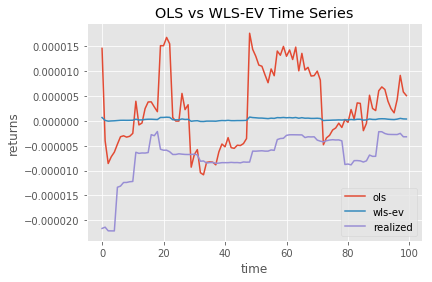

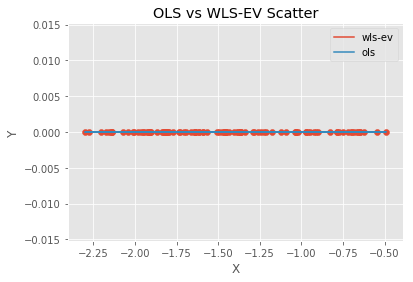

In [29]:
forecast_horizon = 91

# P_skewness_91 = f(Q_skewness_91) + error
print('P_skewness_91 = f(Q_skewness_91) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_91'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), data_pq_var['var_est_skewness1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_91'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
# scatter plot
plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])

### P_kurtosis_91 = f(Q_kurtosis_91) + error

P_kurtosis_91 = f(Q_kurtosis_91) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 91
-------------------------------------------------------------------------------------------------------
betas: [ 0. -0.]
robust bse standard errors: [ 0. -0.]
t-stats: [ 0.2429  0.2409]
In sample R_squared: -0.5872
Out of sample R_squared: 0.997
-------------------------------------------------------------------------------------------------------


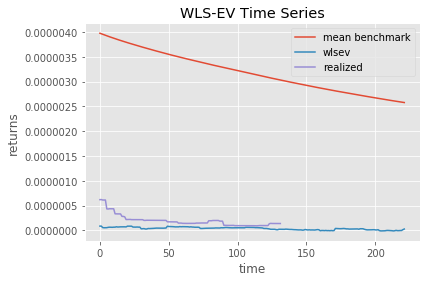

OLS Estimation Results
Forecast Horizon: 91
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 5.1321  5.8919]
In sample R_squared: 0.1387
Out of sample R_squared: 0.1622
-------------------------------------------------------------------------------------------------------


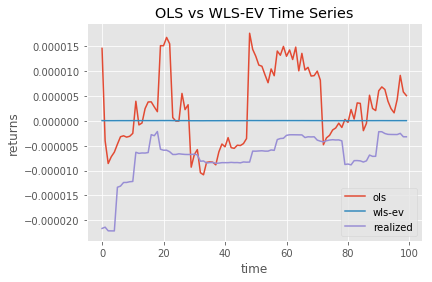

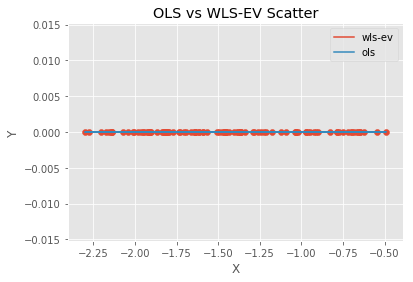

In [30]:
forecast_horizon = 91

# P_kurtosis_91 = f(Q_kurtosis_91) + error
print('P_kurtosis_91 = f(Q_kurtosis_91) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_91'][:-1].as_matrix(), data_pq_var['kurtosis1'][1:].as_matrix(), data_pq_var['var_est_kurtosis1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_91'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
# scatter plot
plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])

### P_skewness_182 = f(Q_skewness_182) + error

P_skewness_182 = f(Q_skewness_182) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 182
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 0.1655  0.1178]
In sample R_squared: -0.0061
Out of sample R_squared: 0.8517
-------------------------------------------------------------------------------------------------------


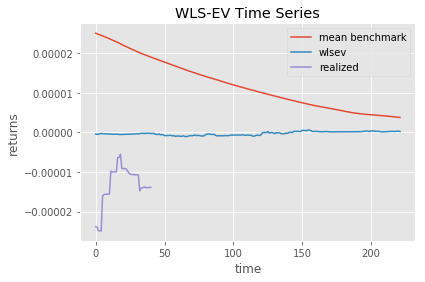

OLS Estimation Results
Forecast Horizon: 182
-------------------------------------------------------------------------------------------------------
betas: [ 0.0001  0.    ]
robust bse standard errors: [ 0.  0.]
t-stats: [ 7.2317  9.1563]
In sample R_squared: 0.3124
Out of sample R_squared: 0.2519
-------------------------------------------------------------------------------------------------------


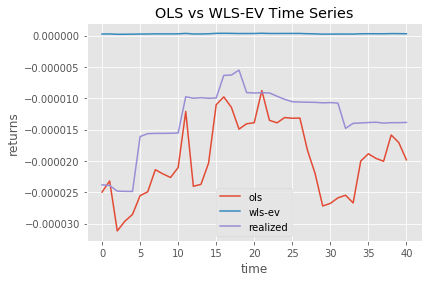

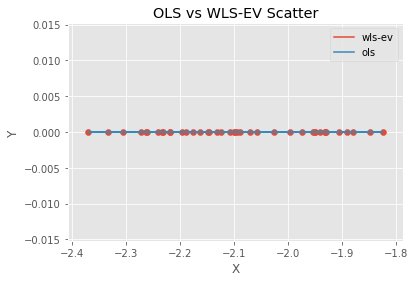

In [31]:
forecast_horizon = 182

# P_skewness_182 = f(Q_skewness_182) + error
print('P_skewness_182 = f(Q_skewness_182) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_182'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), data_pq_var['var_est_skewness1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_182'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
# scatter plot
plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])

### P_kurtosis_182 = f(Q_kurtosis_182) + error

P_kurtosis_182 = f(Q_kurtosis_182) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 182
-------------------------------------------------------------------------------------------------------
betas: [ 0. -0.]
robust bse standard errors: [ 0. -0.]
t-stats: [ 0.2634  0.2881]
In sample R_squared: -0.7524
Out of sample R_squared: 0.9962
-------------------------------------------------------------------------------------------------------


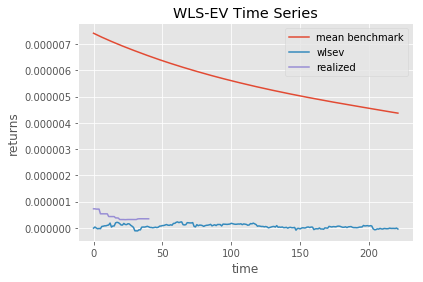

OLS Estimation Results
Forecast Horizon: 182
-------------------------------------------------------------------------------------------------------
betas: [ 0.0001  0.    ]
robust bse standard errors: [ 0.  0.]
t-stats: [ 7.2317  9.1563]
In sample R_squared: 0.3124
Out of sample R_squared: 0.2519
-------------------------------------------------------------------------------------------------------


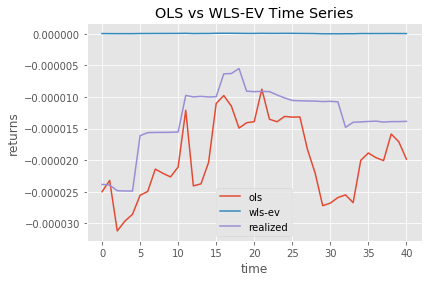

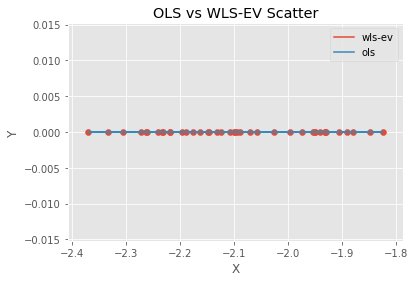

In [32]:
forecast_horizon = 182

# P_kurtosis_182 = f(Q_kurtosis_182) + error
print('P_kurtosis_182 = f(Q_kurtosis_182) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_182'][:-1].as_matrix(), data_pq_var['kurtosis1'][1:].as_matrix(), data_pq_var['var_est_kurtosis1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_182'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
# scatter plot
plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])

### P_skewness_365 = f(Q_skewness_365) + error

P_skewness_365 = f(Q_skewness_365) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 365
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 0.7175  0.6255]
In sample R_squared: 0.0098
Out of sample R_squared: nan
-------------------------------------------------------------------------------------------------------


/Users/tobias/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tobias/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


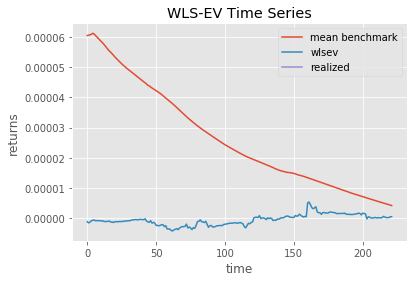

OLS Estimation Results
Forecast Horizon: 365
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 2.8726  2.5055]
In sample R_squared: 0.0485
Out of sample R_squared: nan
-------------------------------------------------------------------------------------------------------


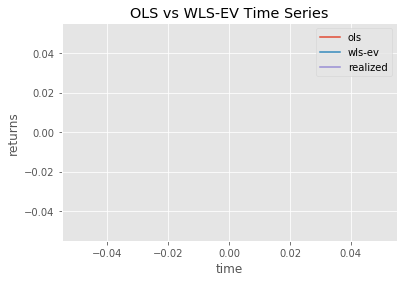

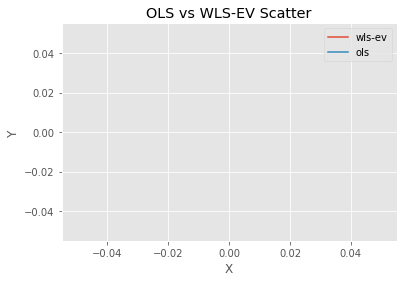

In [33]:
forecast_horizon = 365

# P_skewness_365 = f(Q_skewness_365) + error
print('P_skewness_365 = f(Q_skewness_365) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_365'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), data_pq_var['var_est_skewness1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_365'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
# scatter plot
plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])

### P_kurtosis_365 = f(Q_kurtosis_365) + error

P_kurtosis_365 = f(Q_kurtosis_365) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 365
-------------------------------------------------------------------------------------------------------
betas: [ 0. -0.]
robust bse standard errors: [ 0. -0.]
t-stats: [ 0.2353  0.2406]
In sample R_squared: -1.7179
Out of sample R_squared: nan
-------------------------------------------------------------------------------------------------------


/Users/tobias/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tobias/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


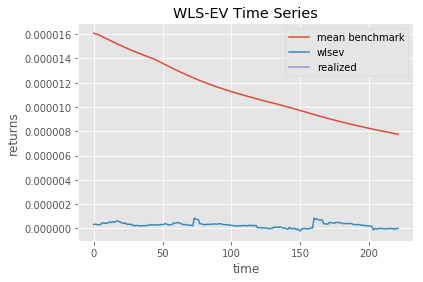

OLS Estimation Results
Forecast Horizon: 365
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 2.8726  2.5055]
In sample R_squared: 0.0485
Out of sample R_squared: nan
-------------------------------------------------------------------------------------------------------


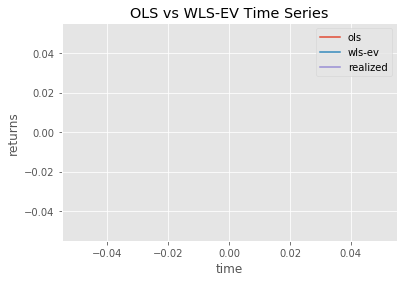

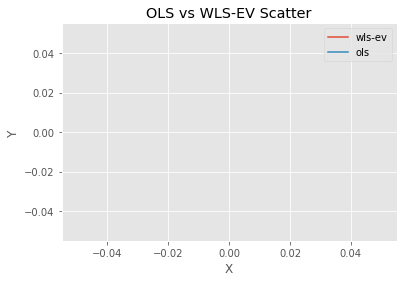

In [34]:
forecast_horizon = 365

# P_kurtosis_365 = f(Q_kurtosis_365) + error
print('P_kurtosis_365 = f(Q_kurtosis_365) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_365'][:-1].as_matrix(), data_pq_var['kurtosis1'][1:].as_matrix(), data_pq_var['var_est_kurtosis1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_365'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
# scatter plot
plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])

### Regress Fama French Factors on Q-Moment